In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import json
# Download necessary NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
def get_stock_data(ticker, start='2020-01-01'):
    data = yf.download(ticker, start=start)
    
    # Ensure the Close column is a 1D array before passing to TA-Lib
    close_prices = data['Close'].astype(float).values.flatten()

    data['RSI'] = talib.RSI(close_prices, timeperiod=14)
    data['MA_10'] = talib.SMA(close_prices, timeperiod=10)
    data['MA_30'] = talib.SMA(close_prices, timeperiod=30)
    data['MA_50'] = talib.SMA(close_prices, timeperiod=50)
    data['MA_200'] = talib.SMA(close_prices, timeperiod=200)

    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    data['Upper_Band'] = upper
    data['Lower_Band'] = lower

    data.dropna(inplace=True)
    return data

In [11]:
def preprocess_lstm_data(df, columns=['Close'], time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[columns])
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# Build LSTM Model with Optimizations
def build_stacked_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [12]:
def train_lstm_model(X_train, y_train, model_name,epoch):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=3.1250e-05, verbose=1)
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=1, callbacks=[lr_scheduler])
    model.save(f"{model_name}.h5")
    return model

# Sentiment Analysis
def get_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score

In [13]:
import os

# Modified function to append results to JSON
def save_results_to_json(ticker, epoch, rmse, mae, mape, r2, filename='results_2020.json'):
    # Check if the file exists and read existing data
    if os.path.isfile(filename):
        with open(filename, 'r') as file:
            try:
                existing_data = json.load(file)
            except json.JSONDecodeError:
                existing_data = []
    else:
        existing_data = []

    # Append new result
    new_result = {
        'Ticker': ticker,
        'Epoch': epoch,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2_Score': r2
    }
    existing_data.append(new_result)

    # Save the updated data back to the file
    with open(filename, 'w') as file:
        json.dump(existing_data, file, indent=4)
    print(f'Results appended to {filename}')

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_ensemble(ticker, forecast_days=30, epoch=50):
    df = get_stock_data(ticker)
    time_step = 60
    
    # Ensure the correct columns are selected for feature engineering (Only 'Close' for indices)
    feature_columns = ['Close']
    
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test = X[-forecast_days:]

    try:
        model = load_model(f"{ticker}_model.h5")
    except:
        model = train_lstm_model(X_train, y_train, ticker, epoch)

    predictions = model.predict(X_test)

    # Create an empty array for inverse transform with correct shape
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))  # (30, 1)
    dummy_array[:, 0] = predictions[:, 0]  # Fill only the Close column

    # Inverse transform using the full shape
    predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the Close column

    # Inverse transform actual y values
    y_actual = np.zeros((y[-forecast_days:].shape[0], len(feature_columns)))
    y_actual[:, 0] = y[-forecast_days:]  # Fill only the Close column
    y_actual = scaler.inverse_transform(y_actual)[:, 0]  # Extract only Close column

    # Sentiment Adjustment
    headline = f"{ticker} stock market update"
    sentiment_score = get_sentiment_score(headline)
    sentiment_adjustment = 1 + (sentiment_score * 0.03)
    adjusted_preds = predictions * sentiment_adjustment

    # Calculate Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_actual, adjusted_preds))
    mae = mean_absolute_error(y_actual, adjusted_preds)
    mape = np.mean(np.abs((y_actual - adjusted_preds) / y_actual)) * 100
    r2 = r2_score(y_actual, adjusted_preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R^2 Score:", r2)
    save_results_to_json(ticker, epoch, rmse, mae, mape, r2)
    # Plot Results
    last_dates = df.index[-forecast_days:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_dates, y_actual, label='Actual')
    plt.plot(last_dates, predictions, label='LSTM Forecast')
    plt.plot(last_dates, adjusted_preds, label='Ensemble Forecast (Sentiment)', linestyle='--')
    plt.title(f"{ticker} - Enhanced Ensemble Forecast ({forecast_days} days), {epoch} Epochs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_multiple_indices(tickers, forecast_days=30, epoch=50):
    plt.figure(figsize=(12, 6))

    for ticker in tickers:
        df = get_stock_data(ticker)

        # Check if data is empty
        if df.empty:
            print(f"⚠️ Warning: No data found for {ticker}. Skipping...")
            continue

        time_step = 60
        feature_columns = ['Close', 'RSI', 'MA_10', 'MA_30', 'MA_50', 'MA_200', 'Upper_Band', 'Lower_Band']

        # Preprocess Data
        try:
            X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
        except ValueError as e:
            print(f"⚠️ Error processing {ticker}: {e}")
            continue  # Skip this index

        if len(X) == 0 or len(y) == 0:
            print(f"⚠️ Warning: Insufficient data for {ticker}. Skipping...")
            continue

        X_train, y_train = X[:-forecast_days], y[:-forecast_days]
        X_test, y_test = X[-forecast_days:], y[-forecast_days:]

        try:
            model = load_model(f"{ticker}_model.h5")
        except:
            model = train_lstm_model(X_train, y_train, ticker, epoch)

        # Make Predictions
        predictions = model.predict(X_test)
        dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))
        dummy_array[:, 0] = predictions[:, 0]
        predictions = scaler.inverse_transform(dummy_array)[:, 0]

        # Inverse transform actual y values
        y_actual = np.zeros((y_test.shape[0], len(feature_columns)))
        y_actual[:, 0] = y_test
        y_actual = scaler.inverse_transform(y_actual)[:, 0]

        # Compute Metrics
        rmse = np.sqrt(mean_squared_error(y_actual, predictions))
        mae = mean_absolute_error(y_actual, predictions)
        mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100
        r2 = r2_score(y_actual, predictions)

        print(f"📊 Performance Metrics for {ticker}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}\n")
        save_results_to_json(ticker, epoch, rmse, mae, mape, r2)
        # Sentiment Adjustment
        headline = f"{ticker} stock market update"
        sentiment_score = get_sentiment_score(headline)
        sentiment_adjustment = 1 + (sentiment_score * 0.03)
        adjusted_preds = predictions * sentiment_adjustment

        # Plot Results for each Index
        last_dates = df.index[-forecast_days:]
        plt.plot(last_dates, adjusted_preds, label=f"{ticker} Forecast")
        plt.plot(last_dates, y_actual, linestyle="dashed", label=f"{ticker} Actual")

    plt.title(f"Stock Market Forecast vs Actual Data ({forecast_days} days)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.1788 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0208 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0119 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0073 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0086 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0063 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0068 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 12/50
3

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
RMSE: 117.65150865469589
MAE: 95.67879351050846
MAPE: 2.6598266416643233
R^2 Score: -0.30761558664384325
Results appended to results_2020.json


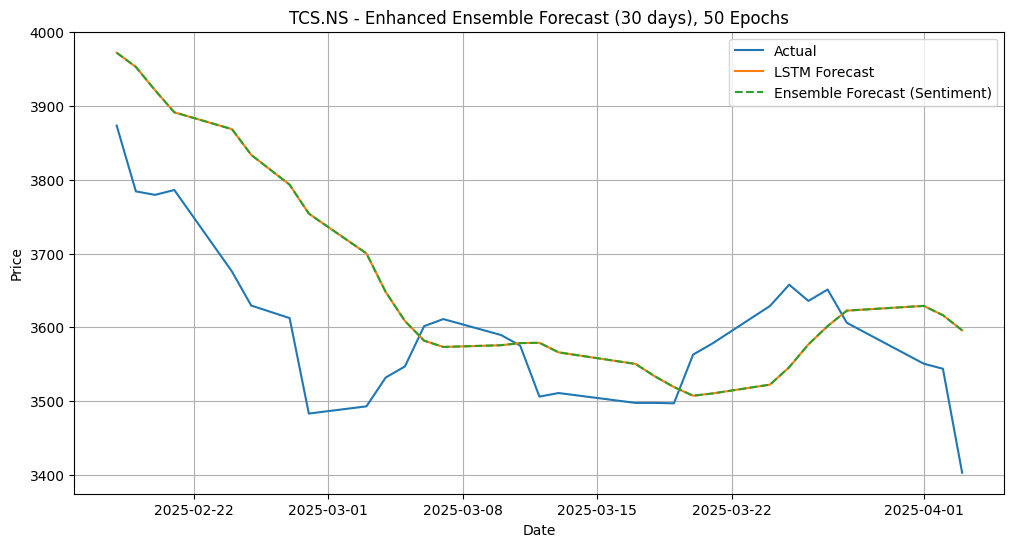

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - loss: 0.0854 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0175 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.0116 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0096 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.0090 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.0075 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0077 - learning_rate: 0.0010
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0063 - learning_rate: 0.0010
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0053 - learning

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
RMSE: 133.93868187127956
MAE: 114.81283622133391
MAPE: 3.2138380924137926
R^2 Score: -0.694716777001799
Results appended to results_2020.json


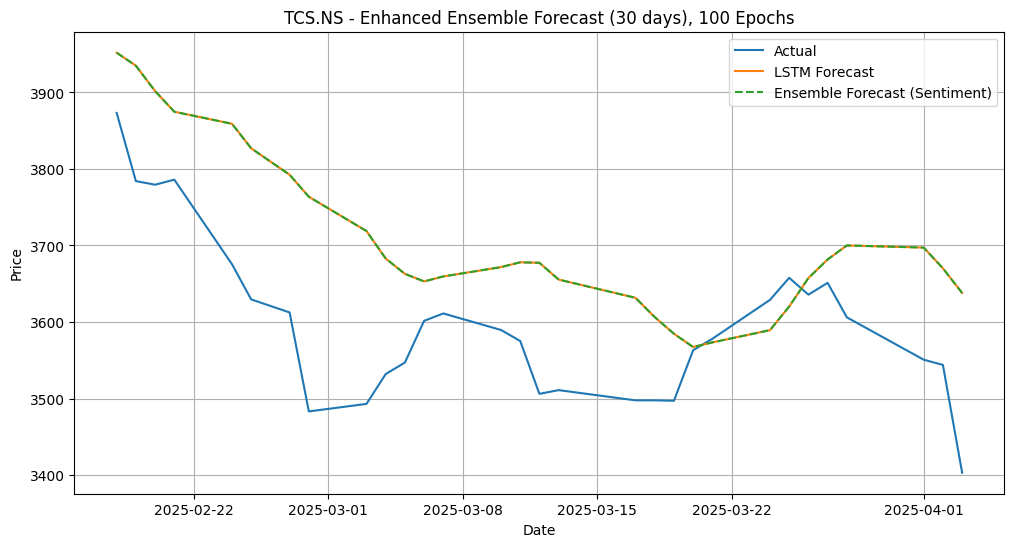

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 97ms/step - loss: 0.0846 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0160 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0099 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0093 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0045 - learning_rate: 0.0010
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0038 - learning_rate

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
RMSE: 87.9002817643616
MAE: 73.80757475490488
MAPE: 2.0576573194199033
R^2 Score: 0.27009620444967675
Results appended to results_2020.json


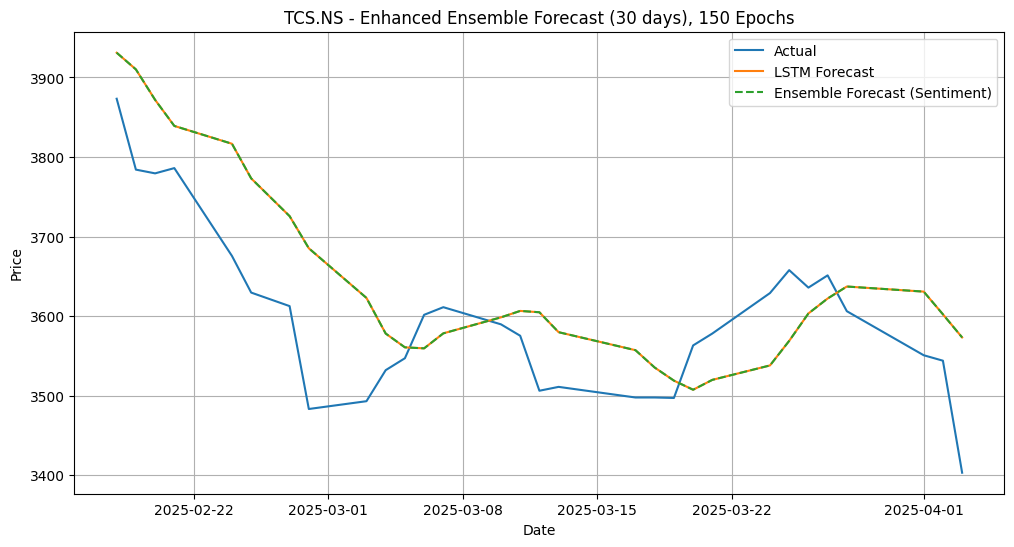

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - loss: 0.0979 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0181 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0124 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.0094 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0088 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0067 - learning_rate: 0.0010
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0069 - learning_rate: 0.0010
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0067 - learning_rate: 0.0010
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0053 - learning_r

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
RMSE: 99.98397697514136
MAE: 84.22739195532704
MAPE: 2.3381878470518718
R^2 Score: 0.055621911016837666
Results appended to results_2020.json


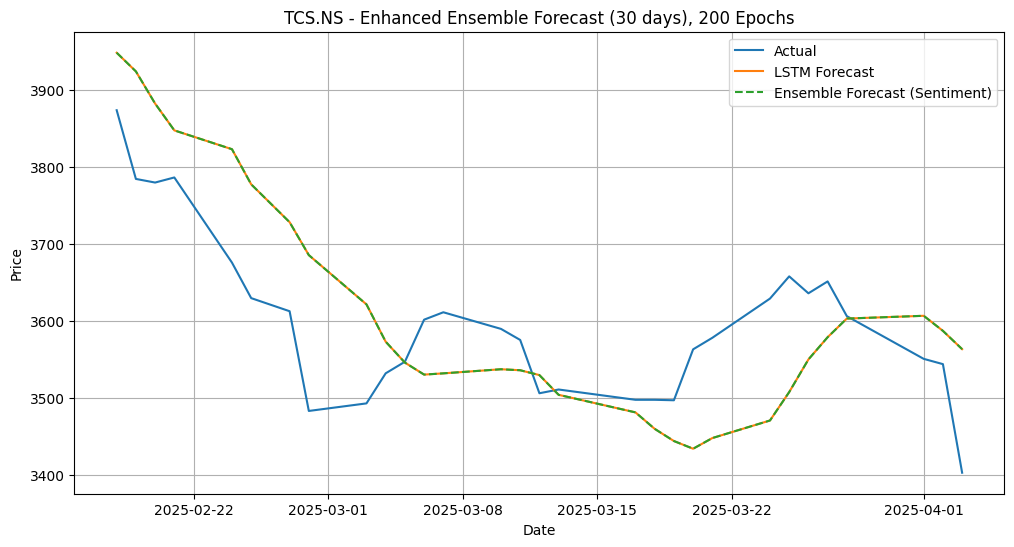

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - loss: 0.0956 - learning_rate: 0.0010
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0124 - learning_rate: 0.0010
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0116 - learning_rate: 0.0010
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0121 - learning_rate: 0.0010
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.0062 - learning_rate: 0.0010
Epoch 6/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0063 - learning_rate: 0.0010
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 9/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 10/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 11/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0051 - learnin

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
RMSE: 94.57624542404422
MAE: 79.14135700415743
MAPE: 2.206514704975354
R^2 Score: 0.15501456012573844
Results appended to results_2020.json


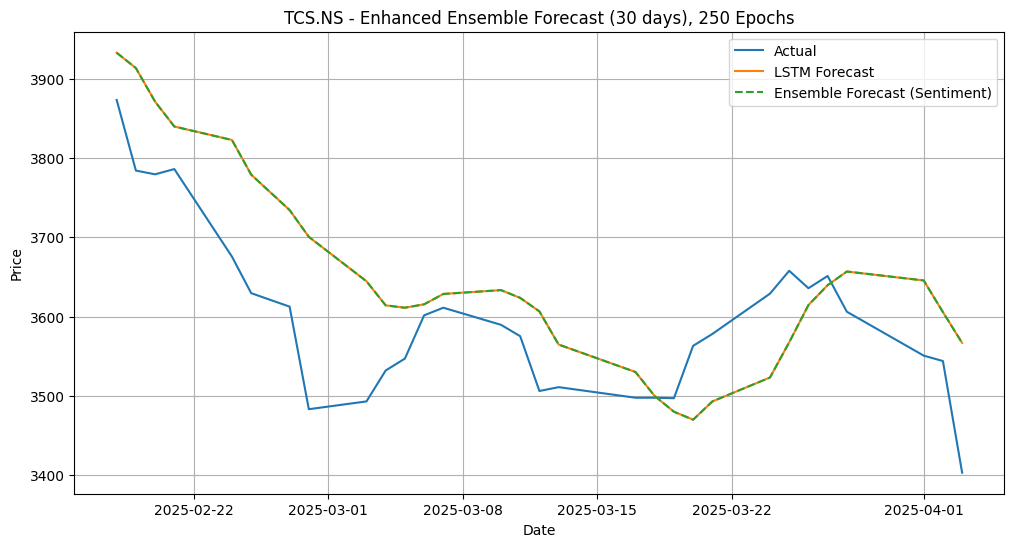

In [16]:
forecast_ensemble("TCS.NS",epoch=50)
forecast_ensemble("TCS.NS",epoch=100)
forecast_ensemble("TCS.NS",epoch=150)
forecast_ensemble("TCS.NS",epoch=200)
forecast_ensemble("TCS.NS",epoch=250)

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - loss: 0.0986 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0174 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0147 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0115 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.0087 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0094 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0087 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0047 - learning_rate: 0.0010
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0051 - learning_rate: 0.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
RMSE: 25.478070446283784
MAE: 19.258004277536443
MAPE: 1.5577504310843104
R^2 Score: 0.4381380335772366
Results appended to results_2020.json


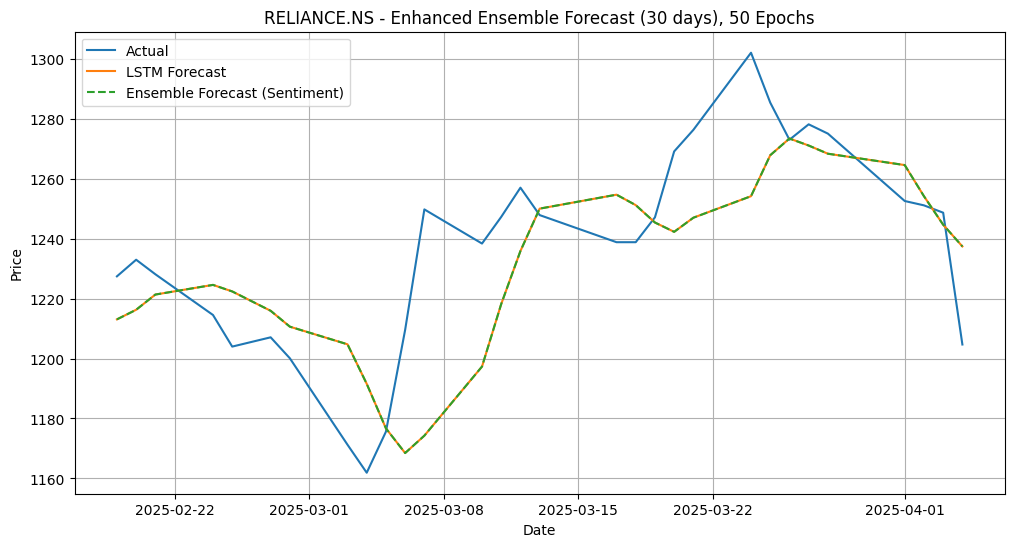

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 117ms/step - loss: 0.0452 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0133 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.0119 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0103 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0067 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0045 - learning_rate: 0.0010
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0065 - learning_rate: 0.0010
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0044 - learnin

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
RMSE: 23.759475614228577
MAE: 18.81171497516122
MAPE: 1.5274907097421948
R^2 Score: 0.5113810915453949
Results appended to results_2020.json


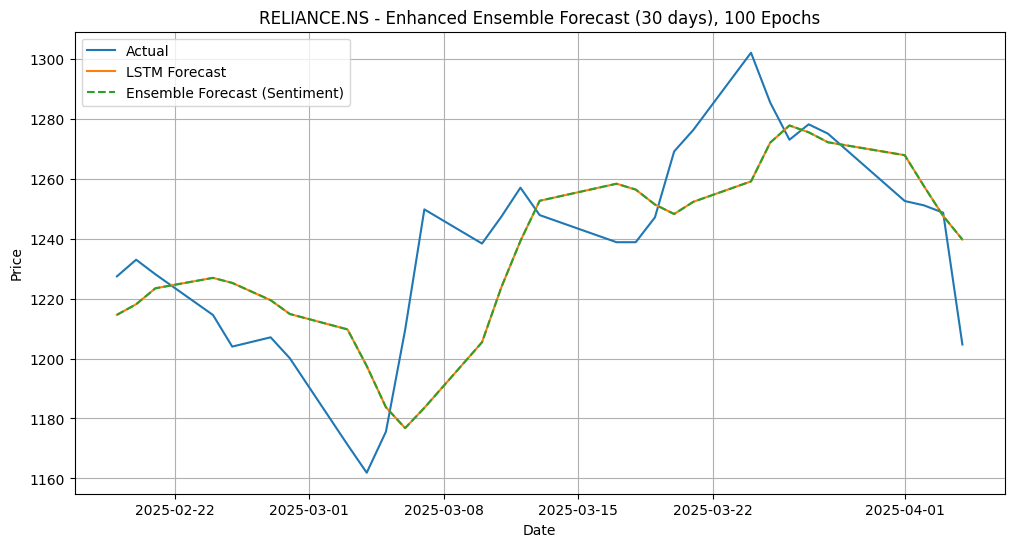

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 144ms/step - loss: 0.0648 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0120 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.0085 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0077 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.0061 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0041 - learning_rate: 0.0010
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.0045 - learning_rate: 0.0010
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.0048 - learnin

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
RMSE: 25.09573696788587
MAE: 20.33359793230217
MAPE: 1.6533018469669456
R^2 Score: 0.45487452984536525
Results appended to results_2020.json


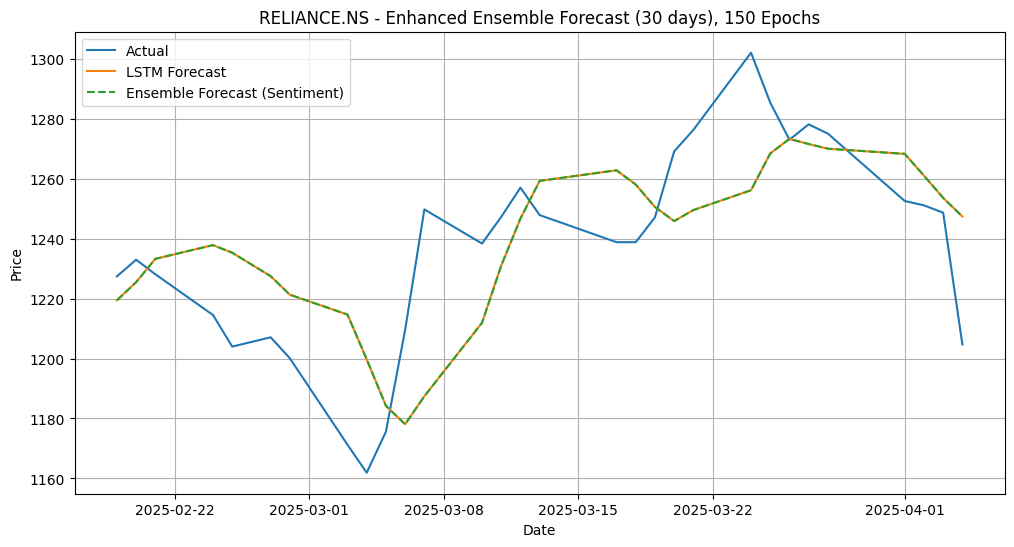

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 132ms/step - loss: 0.1019 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.0210 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0132 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0124 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0066 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0079 - learning_rate: 0.0010
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0081 - learning_rate: 0.0010
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0044 - learning_rate

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
RMSE: 23.22899367444388
MAE: 18.488685790819847
MAPE: 1.5020627579327703
R^2 Score: 0.532956472220869
Results appended to results_2020.json


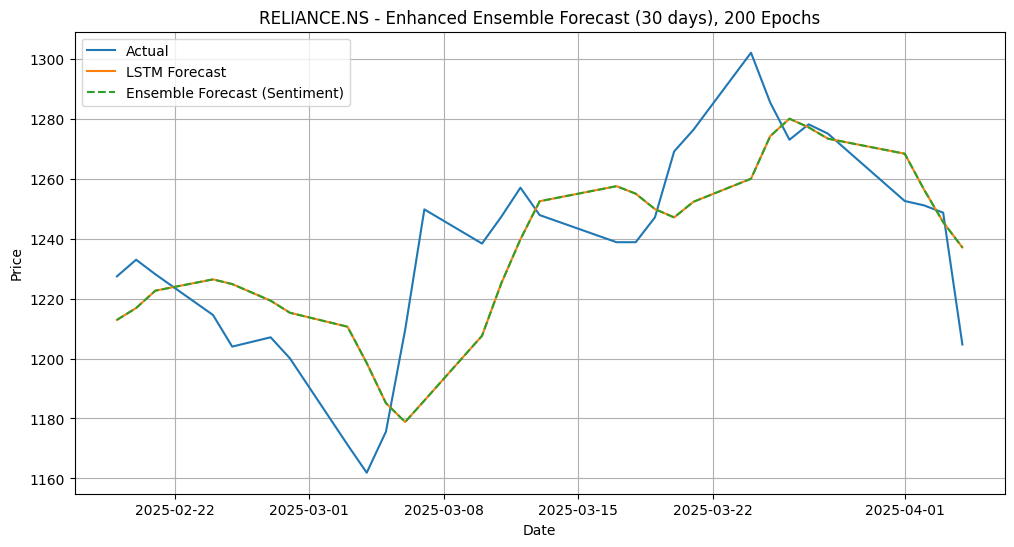

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 0.1034 - learning_rate: 0.0010
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0210 - learning_rate: 0.0010
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0133 - learning_rate: 0.0010
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0103 - learning_rate: 0.0010
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0090 - learning_rate: 0.0010
Epoch 6/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0082 - learning_rate: 0.0010
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.0078 - learning_rate: 0.0010
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0061 - learning_rate: 0.0010
Epoch 9/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0058 - learning_rate: 0.0010
Epoch 10/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 11/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0050 - learning_

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
RMSE: 22.814720263602013
MAE: 17.62467391377395
MAPE: 1.428747845380408
R^2 Score: 0.5494667345482942
Results appended to results_2020.json


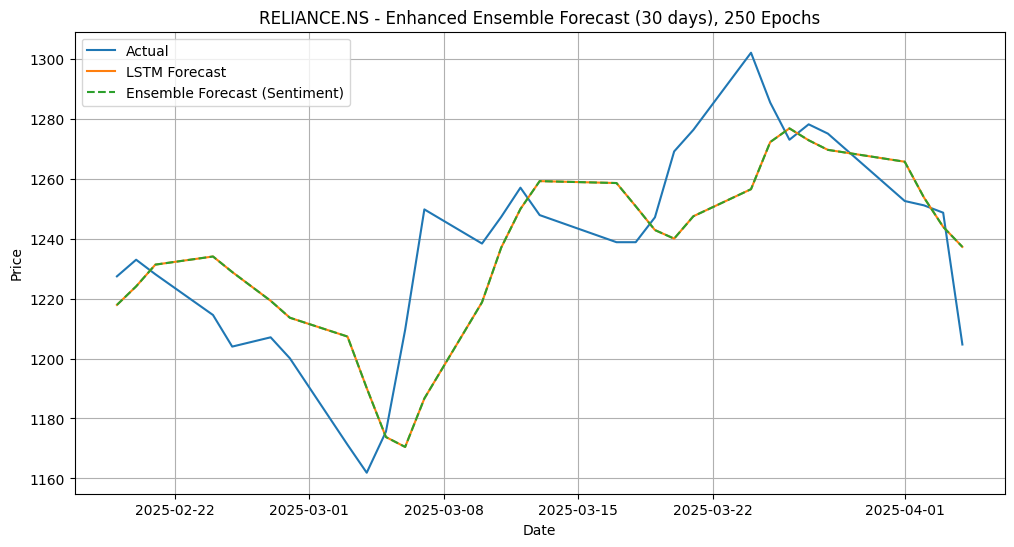

In [17]:

forecast_ensemble("RELIANCE.NS",epoch=50)
forecast_ensemble("RELIANCE.NS",epoch=100)
forecast_ensemble("RELIANCE.NS",epoch=150)
forecast_ensemble("RELIANCE.NS",epoch=200)
forecast_ensemble("RELIANCE.NS",epoch=250)

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - loss: 0.1198 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0134 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0088 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0070 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0060 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0034 - learning_rate: 0.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
📊 Performance Metrics for ^NSEI:
RMSE: 407.03
MAE: 351.46
MAPE: 1.55%
R² Score: 0.2595

Results appended to results_2020.json


[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - loss: 0.1336 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0133 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0112 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0091 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0060 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0071 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0027 - learning_rate: 0.0010
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


📊 Performance Metrics for ^CNX100:
RMSE: 461.51
MAE: 395.12
MAPE: 1.71%
R² Score: 0.2123

Results appended to results_2020.json
⚠️ Warning: No data found for ^CNX500. Skipping...
⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


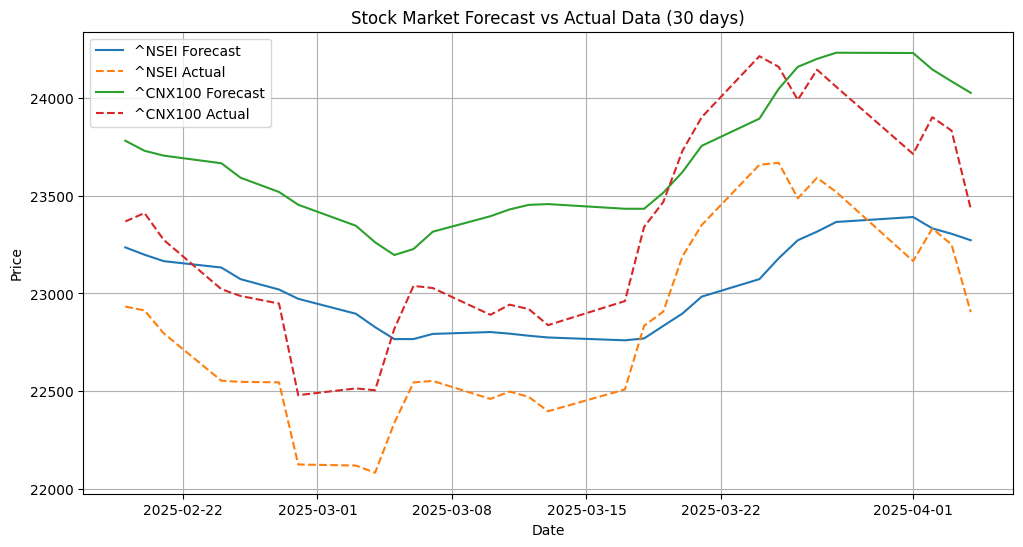

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 0.2170 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0169 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - loss: 0.0087 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.0089 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.0055 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0038 - learning_rate: 0.0010
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0028 - learning_

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
📊 Performance Metrics for ^NSEI:
RMSE: 502.74
MAE: 444.37
MAPE: 1.96%
R² Score: -0.1297

Results appended to results_2020.json


[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - loss: 0.0668 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0136 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0109 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0102 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0027 - learning_rate: 0.0010
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0035 - learning_

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
📊 Performance Metrics for ^CNX100:
RMSE: 408.66
MAE: 343.94
MAPE: 1.47%
R² Score: 0.3824

Results appended to results_2020.json


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

⚠️ Warning: No data found for ^CNX500. Skipping...



ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


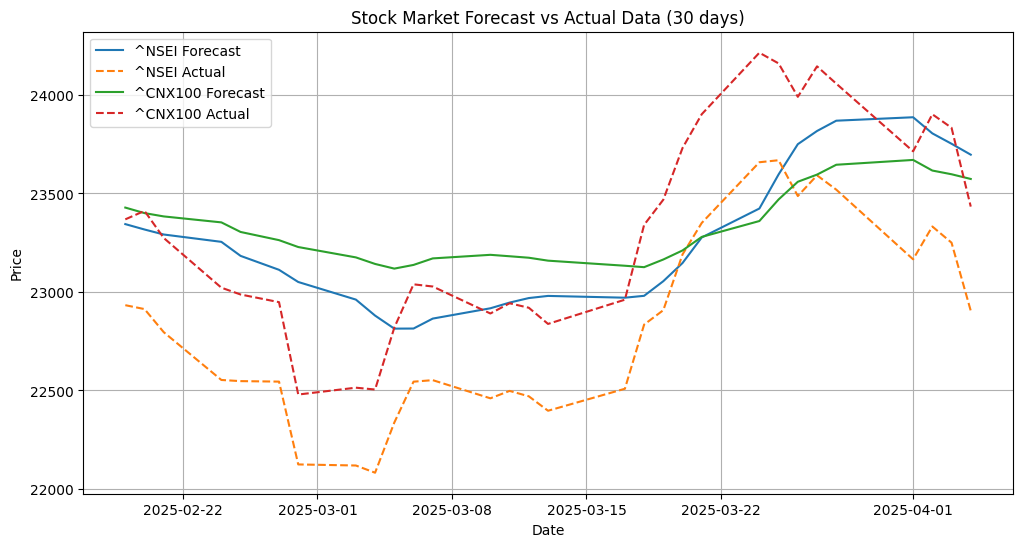

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - loss: 0.1111 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.0217 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0121 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.0083 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0071 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0057 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0063 - learning_rate: 0.0010
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0036 - learning_rate: 0.0010
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0027 - learning_

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
📊 Performance Metrics for ^NSEI:
RMSE: 468.07
MAE: 413.93
MAPE: 1.83%
R² Score: 0.0208

Results appended to results_2020.json


[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 117ms/step - loss: 0.0859 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 0.0144 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0076 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - loss: 0.0063 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.0046 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - loss: 0.0030 - learning_rate: 0.0010
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - loss: 0.0024 - lear

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


[*********************100%***********************]  1 of 1 completed

📊 Performance Metrics for ^CNX100:
RMSE: 349.64
MAE: 295.35
MAPE: 1.27%
R² Score: 0.5479

Results appended to results_2020.json



ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNX500']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^CNX500. Skipping...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^CNXMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^CNXMIDCAP. Skipping...


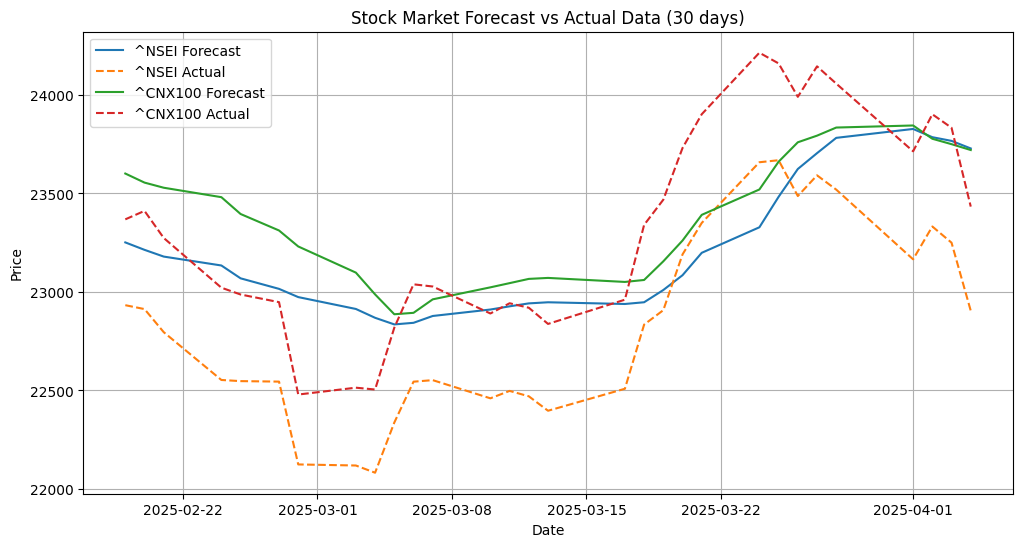

[*********************100%***********************]  1 of 1 completed
c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - loss: 0.0832 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0120 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0090 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 0.0072 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.0075 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.0046 - learning_rate: 0.0010
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0027 - learnin

In [ ]:
nifty_indices = ['^NSEI', '^CNX100', '^CNX500', '^CNXMIDCAP']
forecast_multiple_indices(nifty_indices)
forecast_multiple_indices(nifty_indices,epoch=100)
forecast_multiple_indices(nifty_indices,epoch=150)
forecast_multiple_indices(nifty_indices,epoch=200)
forecast_multiple_indices(nifty_indices,epoch=250)
